In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor, cv
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
data = pd.read_csv("Data/Clean_Wine_Data.csv")
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,Red?,wineType_encoded,Wine_Bins
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,True,1,Connoisseur: Over $100
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,Toro,Tinta de Toro,Bodega Carmen Rodríguez,True,1,Connoisseur: Over $100
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,False,0,Enthusiast: $50-100
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,True,1,Enthusiast: $50-100
4,4,Spain,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,Toro,Tinta de Toro,Numanthia,True,1,Enthusiast: $50-100


In [6]:
with open('Data/wine_reviews.txt', 'r') as file:
    text = file.read().replace('\n', '')
#     print(text)
    tokenized_text=sent_tokenize(text)
#     print(tokenized_text)

# Word Cleaning

In [7]:
import string

In [8]:
    def clean_text(text):
        return text.translate(str.maketrans('', '', string.punctuation)).lower()

    cleanText = clean_text(text)

In [9]:
    tokenized_word=word_tokenize(cleanText)

In [10]:
    fdist = FreqDist(tokenized_word)
    print(fdist)

<FreqDist with 87244 samples and 5322402 outcomes>


In [11]:
    fdist.most_common(10)

[('and', 367938),
 ('the', 224632),
 ('a', 175292),
 ('of', 164783),
 ('with', 134993),
 ('is', 96831),
 ('this', 75037),
 ('wine', 71323),
 ('flavors', 69602),
 ('in', 68131)]

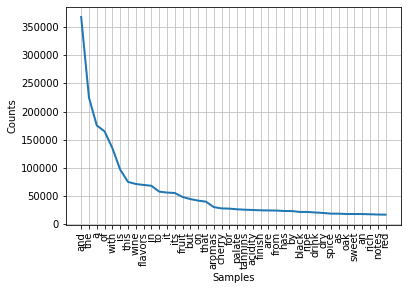

In [12]:
    # Frequency Distribution Plot
    fdist.plot(40,cumulative=False)
    plt.show()

# stopwords

In [13]:
    stop_words=set(stopwords.words("english"))
#     print(stop_words)

In [14]:
    print("The number of stop words provided by NLTK is: " + str(len(stop_words)))

The number of stop words provided by NLTK is: 179


In [15]:
    filtered_sent=[]
    for w in tokenized_word:
        if w not in stop_words:
#             print(w)
            filtered_sent.append(w)
#     print("Tokenized Text:",tokenized_word)
#     print("\n")
#     print("Filterd Text:",filtered_sent)
    

In [16]:
import re
import nltk

In [17]:
    # Regex for only english terms (with dots)
    ENGLISH_RE = re.compile(r'[a-z]+')
    lmtzr = nltk.WordNetLemmatizer()

    lemmatized = []
    for word in tokenized_word:
        w = word.lower()
        # Check english terms
        if not ENGLISH_RE.match(w):
            continue
        # Check stopwords
        if w in stop_words:
            continue
        lemmatized.append(lmtzr.lemmatize(w))
    
    fdist1 = nltk.FreqDist(lemmatized)
    fdist1.most_common(10)

[('wine', 77616),
 ('flavor', 75335),
 ('fruit', 57651),
 ('cherry', 35421),
 ('aroma', 31356),
 ('finish', 29844),
 ('tannin', 26806),
 ('palate', 26471),
 ('acidity', 25082),
 ('spice', 21881)]

In [18]:
# lemmatized

In [19]:
    wpt = nltk.WordPunctTokenizer()
    def normalize_document(doc):
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
        doc = doc.lower()
        doc = doc.strip()
        # tokenize document
        tokens = wpt.tokenize(doc)
        # filter stopwords out of document
        filtered_tokens = [token for token in tokens if token not in stop_words]
        # re-create document from filtered tokens
        doc = ' '.join(filtered_tokens)
        return doc

    normalize_corpus = np.vectorize(normalize_document)

In [20]:
    norm_corpus = normalize_corpus(tokenized_text)
    norm_corpus

array(['tremendous varietal wine hails oakville aged three years oak',
       'juicy redcherry fruit compelling hint caramel greet palate framed elegant fine tannins subtle minty tone background',
       'balanced rewarding start finish years ahead develop nuance', ...,
       'rich pearlike nose followed crisp acidity medium body viscous mouthfeel',
       'finish long redolent pears citrus', ''], dtype='<U688')

In [21]:
    cv = CountVectorizer(min_df=0., max_df=1.)
    cv_matrix = cv.fit_transform(norm_corpus)
    cv_matrix = cv_matrix.toarray()
    cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
    # you can set the n-gram range to 1,2 to get unigrams as well as bigrams
    bv = CountVectorizer(ngram_range=(2,2))
    bv_matrix = bv.fit_transform(norm_corpus)

    bv_matrix = bv_matrix.toarray()
    vocab = bv.get_feature_names()
    pd.DataFrame(bv_matrix, columns=vocab)

,aah sheer,aand focus,aand sugars,aaron pott,abacela continues,abacela crafted,abacela evoke,abacela showcases,abacela vineyards,abacela wines,...,zweigelt touched,zweigelt varietal,zweigelt vinified,zweigelt white,zweigelt wine,zweigelt works,zweigeltan excellent,zweigelts juiciness,zweigelts pepperiness,zwiegelt cabernet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238319,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
    tv = TfidfVectorizer()
    tv_matrix = tv.fit_transform(norm_corpus)

In [24]:
    df = pd.DataFrame(tv_matrix.toarray(), columns=tv.get_feature_names())
#     df

In [25]:
from textblob import TextBlob

In [26]:
#     df

In [80]:
    sentiments = []
    for phrase in norm_corpus:
#         print(phrase)
        sentiments.append(TextBlob(phrase).sentiment.polarity)

    df["Sentiment"] = sentiments

In [81]:
    fig = plt.figure(figsize=(8,5))
    ax = sns.barplot(x=df.Sentiment.unique(),y=df.Sentiment.value_counts());
    ax.set(xlabel='Labels')

NameError: name 'sns' is not defined

<Figure size 576x360 with 0 Axes>

In [56]:
from sklearn.model_selection import train_test_split

In [31]:
from nltk.tokenize import RegexpTokenizer

In [32]:
    data['description']= data['description'].str.lower()
    data['description']= data['description'].apply(lambda elem: re.sub('[^a-zA-Z]',' ', elem))  
#     data['description']

0         this tremendous      varietal wine hails from ...
1         ripe aromas of fig  blackberry and cassis are ...
2         mac watson honors the memory of a wine once ma...
3         this spent    months in     new french oak  an...
4         deep  dense and pure from the opening bell  th...
                                ...                        
134284    many people feel fiano represents southern ita...
134285    offers an intriguing nose with ginger  lime an...
134286    this classic example comes from a cru vineyard...
134287    a perfect salmon shade  with scents of peaches...
134288    more pinot grigios should taste like this  a r...
Name: description, Length: 134289, dtype: object

In [33]:
    tokenizer = RegexpTokenizer(r'\w+')
    words_descriptions = data['description'].apply(tokenizer.tokenize)
    words_descriptions.head()

0    [this, tremendous, varietal, wine, hails, from...
1    [ripe, aromas, of, fig, blackberry, and, cassi...
2    [mac, watson, honors, the, memory, of, a, wine...
3    [this, spent, months, in, new, french, oak, an...
4    [deep, dense, and, pure, from, the, opening, b...
Name: description, dtype: object

In [34]:
    all_words = [word for tokens in words_descriptions for word in tokens]
    data['description_lengths']= [len(tokens) for tokens in words_descriptions]
    VOCAB = sorted(list(set(all_words)))
    print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

5576217 words total, with a vocabulary size of 28409


In [36]:
    ps = PorterStemmer()
    words_description = words_descriptions.apply(lambda elem: [word for word in elem if not word in stop_words])
    words_descriptions = words_descriptions.apply(lambda elem: [ps.stem(word) for word in elem])
    data['description_cleaned'] = words_descriptions.apply(lambda elem: ' '.join(elem))

In [37]:
    def prepare_dataframe(vect, data, features=True):
        vectorized=vect.fit_transform(data['description_cleaned']).toarray()
        vectorized=pd.DataFrame(vectorized)
        if features == True:
            X=data.drop(columns=['points','Unnamed: 0','description','description_cleaned'])
            X=X.fillna(-1)
            print(X.columns)
            X=pd.concat([X.reset_index(drop=True),vectorized.reset_index(drop=True)],axis=1)
            categorical_features_indices =[0,1,3,4,5,6,7,8,9,10]
        else:
            X=vectorized
            categorical_features_indices =[]
        y=data['points']
        return X,y,categorical_features_indices

In [69]:
from sklearn.metrics import classification_report

In [76]:
    def perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test,categorical_features_indices,name):
        model = CatBoostRegressor(
            random_seed = 100,
            loss_function = 'RMSE',
            iterations=800,
        )

        model.fit(
            X_train, y_train,
            cat_features = categorical_features_indices,
            verbose=False,
            eval_set=(X_valid, y_valid),
#             plot=True
        )
#          # Calculate classification report
#         predictions = model.predict(X_test)
#         print(classification_report(y_test, predictions,
#                                     target_names=categorical_features_indices))

        print(name+" technique RMSE on training data: "+ model.score(X_train, y_train).astype(str))
        print(name+" technique RMSE on test data: "+ model.score(X_test, y_test).astype(str))

In [77]:
    def prepare_variable(vect, data, features_append=True):
        X, y , categorical_features_indices = prepare_dataframe(vect, data,features_append)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, 
                                                            random_state=42)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, 
                                                            random_state=52)
        return X_train, y_train,X_valid, y_valid,X_test, y_test, categorical_features_indices

In [78]:
    vect= CountVectorizer(analyzer='word', token_pattern=r'\w+',max_features=500)
    training_variable=prepare_variable(vect, data)
    perform_model(*training_variable, 'Bag of Words Counts')

Index(['country', 'designation', 'price', 'province', 'region_1', 'region_2',
       'variety', 'winery', 'Red?', 'wineType_encoded', 'Wine_Bins',
       'description_lengths'],
      dtype='object')
Bag of Words Counts technique RMSE on training data: 0.853320784528919
Bag of Words Counts technique RMSE on test data: 0.8066914754021643


In [79]:
# Term frequency-inverse document frequency
vect= TfidfVectorizer(analyzer='word', token_pattern=r'\w+',max_features=500)
training_variable=prepare_variable(vect, data)
perform_model(*training_variable, 'TF-IDF')

Index(['country', 'designation', 'price', 'province', 'region_1', 'region_2',
       'variety', 'winery', 'Red?', 'wineType_encoded', 'Wine_Bins',
       'description_lengths'],
      dtype='object')
TF-IDF technique RMSE on training data: 0.8539422804647329
TF-IDF technique RMSE on test data: 0.8052429332061233


In [ ]:
# prediction based only on description 

In [ ]:
vect= CountVectorizer(analyzer='word', token_pattern=r'\w+',max_features=500)
training_variable=prepare_variable(vect, data, False)
perform_model(*training_variable, 'Bag of Words Counts')

In [ ]:
vect= TfidfVectorizer(analyzer='word', token_pattern=r'\w+',max_features=500)
training_variable=prepare_variable(vect, data, False)
perform_model(*training_variable, 'TF-IDF')